# Lung Cancer Image Recognition Final Project
#### Abigail Rhue, Danny Janani
Note: Using Python 3.6 to be compatible with Tensorflow
Code Breakdown:
1. Import data set
2. Get data for single patient as a test
3. 


### 1. Import data set

In this section, libraries are imported, a function is defined to fix a .DS_Store error by ignoring files starting with ".", and the data sets is imported.
 

In [60]:
# Libraries Used
%matplotlib inline 
import cv2
import math
import matplotlib.pyplot as plt
import dicom 
import os
import pandas as pd 
import scipy.ndimage
from skimage import measure, morphology
from skimage.transform import rotate
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import tensorflow as tf
import numpy as np

# Modify os.listdir() to deal with .DS_Store error
def DSlistdir(directory):
    files = os.listdir(directory)
    return [x for x in files if not (x.startswith('.'))]

# Read data set
data_dir = 'Lung/NSCLC-Radiomics/'
patients = DSlistdir(data_dir)
print(patients[0])
stages = pd.read_csv('lung1.clinical.csv', index_col=0)
stages=stages.drop(['age','Clinical.N.Stage','Clinical.M.Stage','Overall.Stage','Histology','gender','Survival.time', 'deadstatus.event'],axis=1)

#Extract values to parse through folders in data set
first_folder= pd.read_csv('FolderAccess.csv')
initial= first_folder.drop('SecondID',axis=1)
second=first_folder.drop('FirstID',axis=1)

initial.head()

LUNG1-001


,FirstID
0,09-18-2008-StudyID-69331
1,01-01-2014-StudyID-85095
2,01-01-2014-StudyID-34270
3,09-24-2006-StudyID-27873
4,01-01-2014-StudyID-93819


### 2. Retrieve data from the first patient as a test

In [34]:
for patient in patients[:1]:
    stage = stages.at[patient, 'clinical.T.Stage']
    path = data_dir + patient +'/'+ initial.iloc[0]['FirstID']+'/'+ second.iloc[0]['SecondID']
    print(path)
    slices = [dicom.read_file(path + '/' + s) for s in DSlistdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
    print(len(slices),stage)
    print(slices[0])


Lung/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-69331/1-82046
134 2.0
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.32722.99.99.41277525157876544037153507755141737313
(0008, 0020) Study Date                          DA: '20080918'
(0008, 0021) Series Date                         DA: '20080918'
(0008, 0022) Acquisition Date                    DA: '20080918'
(0008, 0023) Content Date                        DA: '20080918'
(0008, 0030) Study Time                          TM: '110915.625000'
(0008, 0031) Series Time                         TM: '121748.328000'
(0008, 0032) Acquisition Time                    TM: '113944.541817'
(0008, 0033) Content Time                        TM: '113944.541817'
(0008, 0050) Accession Number              

* Showing that each patient does not have the same number of images associated with it therefore, they must be resized

In [3]:
slice_cnt=np.arange(5)
for i in slice_cnt:
    path= data_dir + patients[i] +'/'+ initial.iloc[i]['FirstID']+'/'+ second.iloc[i]['SecondID']
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    patient=patients[i]
    stage = stages.at[patient, 'clinical.T.Stage']
    print(slices[0].pixel_array.shape, len(slices))

(512, 512) 134
(512, 512) 111
(512, 512) 107
(512, 512) 114
(512, 512) 91


In [4]:
def chunks(a, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(a), n):
        yield a[i:i + n]

def mean(a):
    return sum(a) / len(a)

IMG_PX_SIZE = 150
HM_SLICES = 20

test=np.arange(10)
for i in test:
        stage= stages.at[patients[i], 'clinical.T.Stage']
        path = data_dir + patients[i] +'/'+ initial.iloc[i]['FirstID']+'/'+ second.iloc[i]['SecondID']
        slices = [dicom.read_file(path + '/' + s) for s in DSlistdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []
        
        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
        chunk_sizes = math.ceil(len(slices) / HM_SLICES)
        
        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk) 
        print(len(slices), len(new_slices))

134 20
111 19
107 18
114 19
91 19
114 19
129 19
114 19
105 18
91 19


In [5]:
for i in test:
        stage= stages.at[patients[i], 'clinical.T.Stage']
        path = data_dir + patients[i] +'/'+ initial.iloc[i]['FirstID']+'/'+ second.iloc[i]['SecondID']
        slices = [dicom.read_file(path + '/' + s) for s in DSlistdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
        
        chunk_sizes = math.ceil(len(slices) / HM_SLICES)


        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        print(len(slices), len(new_slices))


134 20
111 20
107 20
114 20
91 20
114 20
129 20
114 20
105 20
91 20


### 3. Define a function to work with Hounsfield units (HU)
Working with Hounsfield units to differentiate between bone and lung when visualizing the data

  * Graphing HU frequency
  * Displaying an image from data set

In [6]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

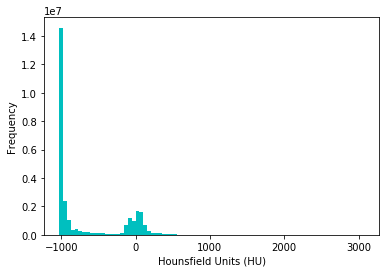

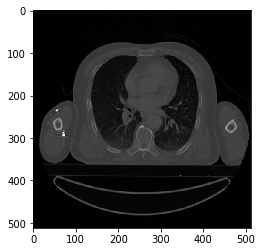

In [42]:
# Plot the frequency of Hounsfield units to visually see which units are most popular
path = data_dir + patients[2] +'/'+ initial.iloc[2]['FirstID']+'/'+ second.iloc[2]['SecondID']
first_patient = [dicom.read_file(path + '/' + s) for s in DSlistdir(path)]
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show a slice from the first patient
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

### 4. Define a function to resample the image
* Resample first for the first image and display dimensions before and after sampling to check the function

In [43]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness, scan[0].PixelSpacing[0], scan[0].PixelSpacing[1]], dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [44]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)


Shape before resampling	 (107, 512, 512)
Shape after resampling	 (321, 500, 500)


### 5. Define a function to plot the images in 3D
First setting the threshold to only show bones based off of HU


In [10]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

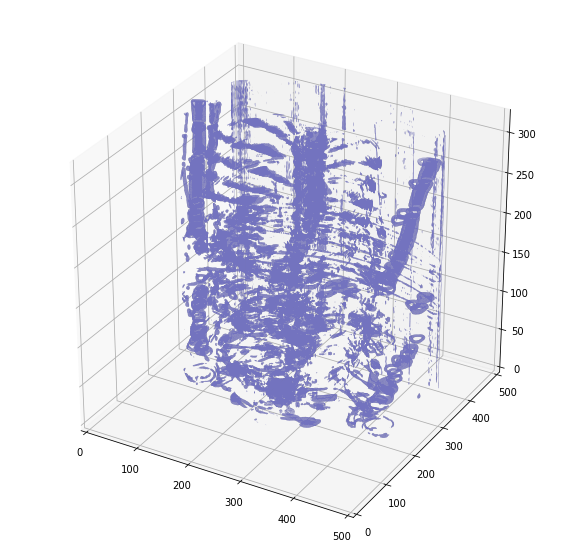

In [52]:
plot_3d(pix_resampled, 450)

### 6. Visualize segmented lungs
Plot the lungs without the bone structure
  * Filled lung structure
  * Unfilled lung structure
  * Difference between lungs with and without filling

In [46]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
    return binary_image


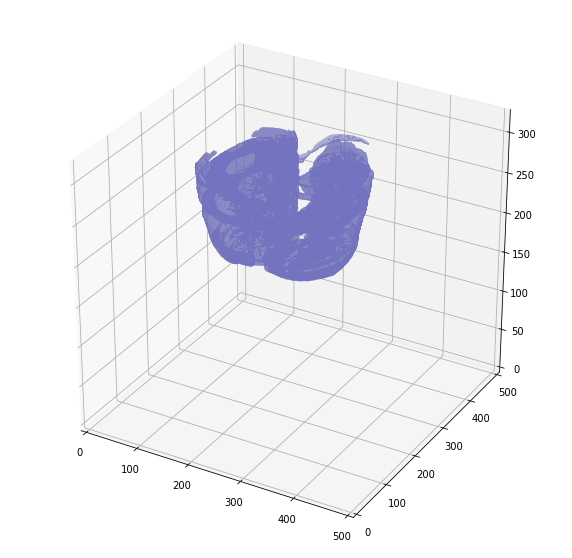

In [47]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)
plot_3d(segmented_lungs, 0)

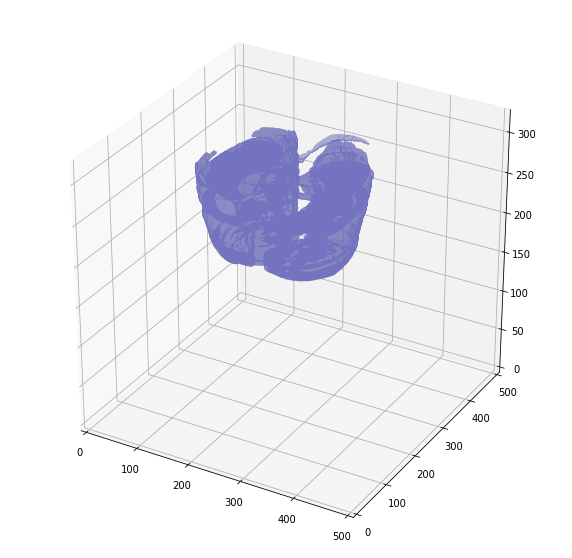

In [49]:
plot_3d(segmented_lungs_fill, 0)

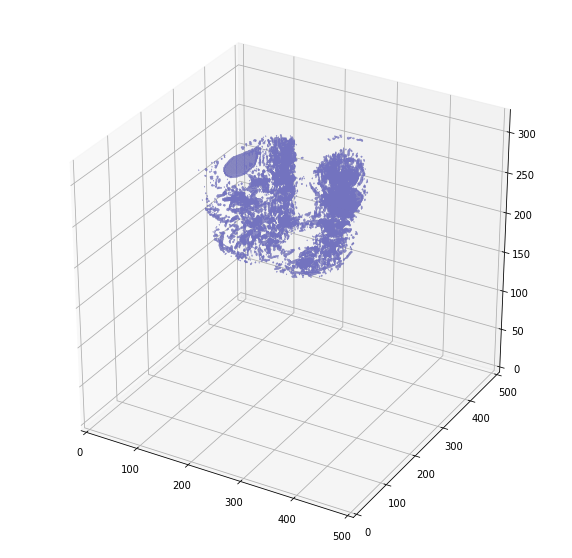

In [50]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

### 10. Define function to do something

hkb

In [ ]:
much_data = []
test = np.arange(20)
for i in enumerate(test):
    print(i[0])
    stage= stages.at[patients[i[0]], 'clinical.T.Stage']
    if stage == 1.0: stage=np.array([0,0])
    elif stage == 2.0: stage=np.array([0,1])
    elif stage == 3.0: stage=np.array([1,0])
    elif stage == 4.0: stage=np.array([1,1])
    path = data_dir + patients[i[0]] +'/'+ initial.iloc[i[0]]['FirstID']+'/'+ second.iloc[i[0]]['SecondID']

    patient_data = [dicom.read_file(path + '/' + s) for s in DSlistdir(path)]
    patient_pixels = get_pixels_hu(patient_data)
    pix_resampled, spacing = resample(patient_pixels,patient_data, [1,1,1])
    [x,y,z]=pix_resampled.shape
    pix_resampled=np.lib.pad(pix_resampled,(500-x,0),'constant',constant_values=(0,0))
    segmented_lungs = segment_lung_mask(pix_resampled, False)
    segmented_lungs_fill = segment_lung_mask(pix_resampled, True)
    img_data= segmented_lungs_fill - segmented_lungs
    much_data.append([img_data,label])

    
np.save('muchdata-{}-{}-{}.npy'.format(a,b,c), much_data)
print('dont')

0
1


In [17]:
def process_data(patients,stages,i, new_spacing=[1,1,1]):
   
    stage= stages.at[patients[i], 'clinical.T.Stage']
    path = data_dir + patients[i] +'/'+ initial.iloc[i]['FirstID']+'/'+ second.iloc[i]['SecondID']
    slices = [dicom.read_file(path + '/' + s) for s in DSlistdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    new_slices = []

    
    patient = [dicom.read_file(path + '/' + s) for s in DSlistdir(path)]
    patient_pixels = get_pixels_hu(patient)

    spacing = np.array([patient[0].SliceThickness, patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]], dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape =patient_pixels.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / patient_pixels.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(patient_pixels, real_resize_factor, mode='nearest')

    return image, stage, patient_pixels


much_data = []
nums=np.arange(3) 
print(nums)
for i in enumerate(nums):
        img_data,stage,patient_pixels = process_data(patients,stages,i[0],new_spacing=[1,1,1])
        much_data.append([img_data,stage])
        print(patient_pixels.shape)
        print(img_data.shape)
        print(stage)

np.save('muchdata-{}-{}-{}.npy'.format(1,2,3), much_data)

In [18]:

IMG_SIZE_PX = 50
SLICE_COUNT = 40

def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


def mean(a):
    return sum(a) / len(a)

test=np.arange(SLICE_COUNT)
def process_data(i,patients,stages,img_px_size=50, hm_slices=20, visualize=False):
    stage= stages.at[patients[i], 'clinical.T.Stage']
    path = data_dir + patients[i] +'/'+ initial.iloc[i]['FirstID']+'/'+ second.iloc[i]['SecondID']
    slices = [dicom.read_file(path + '/' + s) for s in DSlistdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    new_slices = []

    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]

    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        
    if len(new_slices) == hm_slices-3:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

    if stage == 1.0: stage=np.array([0,0])
    elif stage == 2.0: stage=np.array([0,1])
    elif stage == 3.0: stage=np.array([1,0])
    elif stage == 4.0: stage=np.array([1,1])

    return np.array(new_slices),stage

#                                               stage 1 for real.
much_data = []

for i in test:
    img_data,label = process_data(i,patients,stages,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
    #print(img_data.shape,label)
    much_data.append([img_data,label])
    print(label)

np.save('muchdata-{}-{}-{}.npy'.format(1,2,3), much_data)

[0 1]
[0 1]
[0 1]
[0 1]
[1 1]
[1 0]
[0 1]
[0 1]
[0 1]
[1 1]
[1 1]
[1 0]
[0 1]
[1 1]
[0 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[1 1]
[0 1]
[0 0]
[0 0]
[0 1]
[1 1]
[0 1]
[0 1]
[1 1]
[1 0]
[0 1]
[0 1]
[0 0]
[0 1]
[0 0]
[1 0]


IMG_SIZE_PX = 50
SLICE_COUNT = 5
slice_cnt=np.arange(SLICE_COUNT)

def process_data(patients,stages,img_px_size=50, hm_slices=20, visualize=False, image, scan, new_spacing=[1,1,1]):
    
    for i in test:
        stage= stages.at[patients[i], 'clinical.T.Stage']
        path = data_dir + patients[i] +'/'+ initial.iloc[i]['FirstID']+'/'+ second.iloc[i]['SecondID']
        slices = [dicom.read_file(path + '/' + s) for s in DSlistdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []
        
        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
        
        chunk_sizes = math.ceil(len(slices) / HM_SLICES)
        
    def resample(image, scan, new_spacing=[1,1,1]):
        patient = [dicom.read_file(path + '/' + s) for s in DSlistdir(path)]
        patient_pixels = get_pixels_hu(first_patient)
        
        spacing = np.array([patient[i].SliceThickness, patient[i].PixelSpacing[i], patient[i].PixelSpacing[1]], dtype=np.float32)

        resize_factor = spacing / new_spacing
        new_real_shape =patient_pixels.shape * resize_factor
        new_shape = np.round(new_real_shape)
        real_resize_factor = new_shape / patient_pixels.shape
        new_spacing = spacing / real_resize_factor
    
        image = scipy.ndimage.interpolation.zoom(patient_pixels, real_resize_factor, mode='nearest')
    
    return image, new_spacing
    
    
    
    
    
    
    stage = stages.at[patient, 'clinical.T.Stage']
    path = data_dir + patient[:SLICE_COUNT] +'/'+ initial.iloc[:SLICE_COUNT]['FirstID']+'/'+ second.iloc[:SLICE_COUNT]['SecondID']
    for i in slice_cnt:
        path = data_dir + patients[i] +'/'+ initial.iloc[i]['FirstID']+'/'+ second.iloc[i]['SecondID']
    
    slices = [dicom.read_file(path + '/' + s) for s in DSlistdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    
    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

    if stage == 1: stage=np.array([0,1])
    elif stage == 0: stage=np.array([1,0])
        
    #return np.array(new_slices),label

much_data = []
for num,patient in enumerate(patients[:5]):
    if num % 100 == 0:
        print(num)
        
        img_data,label = process_data(patient,stages,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
        much_data.append([img_data,label])
    

np.save('muchdata-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)


### 10. Convolution

In [19]:


n_classes = 2

batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate=0.8
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')
    print('ok')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')
    print('y')

In [20]:
def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']
    print('did')
    return output


In [21]:
much_data = np.load('muchdata-1-2-3.npy')
# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = much_data[:-2]
validation_data = much_data[-2:]
print(train_data.shape)
print(validation_data.shape)

(38, 2)
(2, 2)


In [22]:
much_data = np.load('muchdata-1-2-3.npy')
# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = much_data[:-2]
validation_data = much_data[-2:]

def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    hm_epochs = 2
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                    # input tensor. Not sure why, will have to look into it. Guessing it's
                    # one of the depths that doesn't come to 20.
                    pass
                    #print(str(e))
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
            
            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)


train_neural_network(x)


did
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 1 completed out of 2 loss: 12862190304.0


InvalidArgumentError: Input to reshape is a tensor with 160000 values, but the requested shape requires a multiple of 100000
	 [[node Reshape (defined at <ipython-input-20-bbd68b05f903>:16)  = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_Placeholder_0_0, Reshape/shape)]]

Caused by op 'Reshape', defined at:
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\asyncio\base_events.py", line 427, in run_forever
    self._run_once()
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\asyncio\base_events.py", line 1440, in _run_once
    handle._run()
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 1080, in __init__
    self.run()
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-1051a754df30>", line 48, in <module>
    train_neural_network(x)
  File "<ipython-input-22-1051a754df30>", line 7, in train_neural_network
    prediction = convolutional_neural_network(x)
  File "<ipython-input-20-bbd68b05f903>", line 16, in convolutional_neural_network
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 7759, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "c:\users\abigail\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 160000 values, but the requested shape requires a multiple of 100000
	 [[node Reshape (defined at <ipython-input-20-bbd68b05f903>:16)  = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_Placeholder_0_0, Reshape/shape)]]


In [ ]:
#stages.clinicalTStage.value_counts()

In [ ]:
#stages.ix[-20:].clinicalTStage.value_counts()